In [14]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [16]:
PATH = "/home/ubuntu/fastai/courses/dl1/data/statoil/"
%cd "/home/ubuntu/fastai/courses/dl1/data/statoil/"

/home/ubuntu/data/statoil


In [17]:
#Load train and test data
train = pd.read_json("train.json")
test = pd.read_json("test.json")


In [18]:
%rm -r  "/home/ubuntu/fastai/courses/dl1/data/statoil/train/"
%rm -r  "/home/ubuntu/fastai/courses/dl1/data/statoil/valid/"
%rm -r  "/home/ubuntu/fastai/courses/dl1/data/statoil/test/"


In [19]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([0.3*X_band_1[:, :, :, np.newaxis], 0.6*X_band_2[:, :, :, np.newaxis],(0.1*(X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

#X_train = [(sample / sample.max())*255 for sample in X_train]

In [20]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([0.3*X_band_test_1[:, :, :, np.newaxis], 0.6*X_band_test_2[:, :, :, np.newaxis], (0.1*(X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [21]:
%mkdir train
import sys
lenTrain = len(train)
print(lenTrain)
for i in range(0,lenTrain):
    isIceberg = (train.ix[i]['is_iceberg'])
    if(isIceberg == 1):scipy.misc.imsave('train/iceberg.'+str(i)+'.jpg', X_train[i])
    else:scipy.misc.imsave('train/ship.'+str(i)+'.jpg', X_train[i])


1604


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [22]:
%mkdir valid
%cd $PATH/train
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(400): os.rename(shuf[i], PATH+'/valid/' + shuf[i])

/home/ubuntu/data/statoil/train


In [23]:
%cd $PATH/valid
%mkdir iceberg
%mkdir ship
%mv iceberg.*.jpg iceberg/
%mv ship.*.jpg ship/

/home/ubuntu/data/statoil/valid


In [24]:
%cd $PATH/train
%mkdir iceberg
%mkdir ship
%mv iceberg.*.jpg iceberg/
%mv ship.*.jpg ship/

/home/ubuntu/data/statoil/train


In [25]:
%cd $PATH
%mkdir test
import scipy.misc
lenTest = len(test)
print(lenTest)
for i in range(lenTest):
    scipy.misc.imsave('test/'+str(i)+'.jpg', X_test[i])


/home/ubuntu/data/statoil
8424


In [26]:
arch=resnet50
sz = 224
#sz = 75
data = ImageClassifierData.from_paths(PATH, bs = 64,tfms=tfms_from_model(arch, sz,aug_tfms=transforms_basic,max_zoom = 1.0), trn_name='train',val_name='valid', test_name = 'test',num_workers=8)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 3)

test_preds = learn.predict(is_test = True)
print(test_preds.shape)

100%|██████████| 132/132 [01:01<00:00,  2.16it/s]


A Jupyter Widget

[ 0.       0.18163  0.51577  0.70982]                     
[ 1.       0.23992  0.39035  0.78348]                     
[ 2.       0.27395  0.36208  0.81473]                      

(8424, 2)


In [27]:
lrf=learn.lr_find()

A Jupyter Widget

 84%|████████▍ | 16/19 [00:00<00:00, 17.70it/s, loss=0.981]


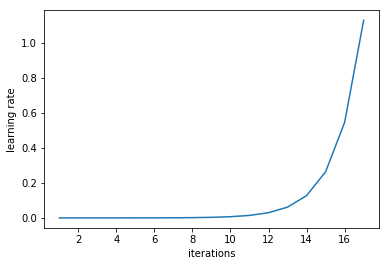

In [28]:
learn.sched.plot_lr()

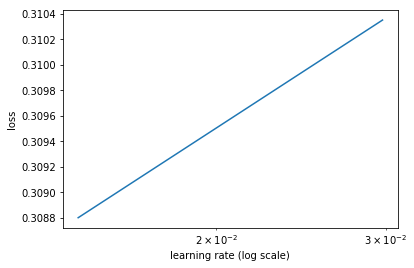

In [29]:
learn.sched.plot()

## Differential learning and finetuning.

In [30]:
learn.precompute=False
learn.fit(1e-2, 1, cycle_len=1)

A Jupyter Widget

[ 0.       0.12523  0.34212  0.83036]                      



In [31]:
#This give the validation accuracy and log loss
from sklearn import metrics

log_preds,y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)


(0.82999999999999996, 0.34470728480323487)

In [32]:
learn.unfreeze()
lr = np.array([1e-2,3*1e-2,9*1e-2])

In [33]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=3)

A Jupyter Widget

[ 0.       0.1997   2.26601  0.47321]                      
[ 1.       0.30075  0.93976  0.84375]                      
[ 2.       0.30337  0.36149  0.87723]                      
[ 3.       0.27338  0.31531  0.86607]                      
[ 4.       0.25706  0.37872  0.86607]                      
[ 5.       0.26316  0.70089  0.86161]                      
[ 6.       0.25496  0.33742  0.88839]                      
[ 7.       0.21612  0.37581  0.86607]                      
[ 8.       0.19597  0.34421  0.86607]                      
[ 9.       0.15734  0.43098  0.87054]                      
[ 10.        0.12898   0.3748    0.89732]                  
[ 11.        0.1037    0.39933   0.89062]                  
[ 12.        0.08092   0.39559   0.89062]                   



In [34]:
#for file submission
#Actual test files are used for submission
test_preds = learn.TTA(is_test = True)
submission = pd.DataFrame()
submission['id'] = test['id']
submission['is_iceberg'] = pd.DataFrame({'is_iceberg':list(np.exp(test_preds[0][:][:,0]))})
submission.to_csv('sub.csv', index=False)
